<a href="https://colab.research.google.com/github/JASONZ777/4D_radar_simulator_PointNet/blob/main/senti_ana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Design a hard prompt

# Method 1: Prompt-BERT (add a classification layer)

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
# define a hard prompt, and its ID
def get_prompt(x):
    prompt = f'总体上来说很[MASK]: {x}'
    return {
        'prompt': prompt,
        'mask_id': prompt.find('[MASK]') # since only one [MASK], find the ID
    }

# map the label to the word in the dictionary
# (tokenizer, words with similiar meanings have similar embeddings, that's why we could calculate the loss)
def map_label(tokenizer):
    return {
        '1': {'token': '好', 'id': tokenizer.convert_tokens_to_ids("好")},
        '0': {'token': '差', 'id': tokenizer.convert_tokens_to_ids("差")}
    }


In [ ]:
# a testing from Huggingface
from transformers import AutoTokenizer

checkpoint = "bert-base-chinese"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

comment = '这个宾馆比较陈旧了，特价的房间也很一般。'

print('verbalizer:', map_label(tokenizer))

prompt_data = get_prompt(comment)
prompt, mask_offset = prompt_data['prompt'], prompt_data['mask_id']

encoding = tokenizer(prompt, truncation=True)
tokens = encoding.tokens()
mask_idx = encoding.char_to_token(mask_offset)

print('prompt:', prompt)
print('prompt tokens:', tokens)
print('mask idx:', mask_idx)

c:\Users\JASONZ7\.conda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


verbalizer: {'1': {'token': '好', 'id': 1962}, '0': {'token': '差', 'id': 2345}}
prompt: 总体上来说很[MASK]: 这个宾馆比较陈旧了，特价的房间也很一般。
prompt tokens: ['[CLS]', '总', '体', '上', '来', '说', '很', '[MASK]', ':', '这', '个', '宾', '馆', '比', '较', '陈', '旧', '了', '，', '特', '价', '的', '房', '间', '也', '很', '一', '般', '。', '[SEP]']
mask idx: 7


## Upload dataset combined with prompts

In [ ]:
from torch.utils.data import Dataset

class upload_dataset(Dataset):
    def __init__(self, data_file):
        self.data = self.load_data(data_file)

    def load_data(self, data_file):
        Data = {}
        with open(data_file, 'rt', encoding='utf-8') as f:
            for idx, line in enumerate(f):
                items = line.strip().split('\t')
                prompts = get_prompt(items[0])
                assert len(items) == 2
                Data[idx] = {
                    'comment': items[0],
                    'label': int(items[1]),
                    'prompt': prompts['prompt'],
                    'mask_id': prompts['mask_id']
                }
        return Data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
# testing
train_data = upload_dataset('chnsenticorp/train/part.0')
valid_data = upload_dataset('chnsenticorp/dev/part.0')
test_data = upload_dataset('chnsenticorp/test/part.0')
print(f'train set size: {len(train_data)}')
print(f'valid set size: {len(valid_data)}')
print(f'test set size: {len(test_data)}')
print(next(iter(train_data)))

train set size: 9600
valid set size: 1200
test set size: 1200
{'comment': '选择珠江花园的原因就是方便，有电动扶梯直接到达海边，周围餐馆、食廊、商场、超市、摊位一应俱全。酒店装修一般，但还算整洁。 泳池在大堂的屋顶，因此很小，不过女儿倒是喜欢。 包的早餐是西式的，还算丰富。 服务吗，一般', 'label': 1, 'prompt': '总体上来说很[MASK]: 选择珠江花园的原因就是方便，有电动扶梯直接到达海边，周围餐馆、食廊、商场、超市、摊位一应俱全。酒店装修一般，但还算整洁。 泳池在大堂的屋顶，因此很小，不过女儿倒是喜欢。 包的早餐是西式的，还算丰富。 服务吗，一般', 'mask_id': 6}


## Data preprocessing

In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
checkpoint = 'bert-base-chinese'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# find the id of the label defined in tokenizer
label = map_label(tokenizer)
pos_id, neg_id = label['1']['id'], label['0']['id']
# Dataloader, in NLP we usually use collate_fn to do the padding to make sure samples have the same sequence length
def collate(batch_samples): # operate on each batch
    batch_sentence = []
    batch_label = []
    batch_mask_id = []
    max_length = 0
    for sample in batch_samples:
        batch_sentence.append(sample['prompt'])
        encoding = tokenizer(sample['prompt'], truncation=True)
        max_length = max(max_length, len(encoding.tokens())) # dynamic padding to the longest
        mask_idx = encoding.char_to_token(sample['mask_id']) # convert the character id of mask in prompts to token id in tokenized sentence
        batch_mask_id.append(mask_idx) # if pre-fix prompt, mask id will be the same
        batch_label.append(sample['label'])
    batch_inputs = tokenizer(batch_sentence, max_length=max_length, padding=True, truncation=True, return_tensors="pt")
    label_id = [neg_id, pos_id]
    return {
        'batch_inputs':batch_inputs,
        'batch_mask_id': batch_mask_id,
        'label_id': label_id,
        'labels': batch_label

    }


In [ ]:
# a testing for dataloader
# batch_data = next(iter(train_loader))
# print('batch_X shape:', {k: v.shape for k, v in batch_data['batch_inputs'].items()})
# print(batch_data['batch_inputs'])
# print(batch_data['batch_mask_id'])
# print(batch_data['label_id'])
# print(batch_data['labels'])

## Build the model

Look into the structure of the pre-trained model

In [ ]:
from transformers import AutoModelForMaskedLM, BertModel # the difference is that the former class contains a head layer for specific MLM task;
# BertModel is the base class, and we need to define the head layer e.g. the softmax

checkpoint = 'bert-base-chinese'
pre_trained_model = BertModel.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
vocab_size = len(tokenizer)
print(pre_trained_model)
print(vocab_size)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(21128, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

Frozen all the parameters + Add the classiifcation layer (trainable)

In [ ]:
for param in pre_trained_model.parameters():
    param.requires_grad_(False)

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, vocab_size, model):
        super().__init__()
        self.fc = torch.nn.Linear(768, vocab_size)
        self.md = model

    def forward(self, batch_inputs, batch_mask_id, label_id, labels=None):
        input_data = batch_inputs
        with torch.no_grad():
            out = self.md(**input_data)

        out = self.fc(out.last_hidden_state[:, batch_mask_id[0]]) # only works when the masking position is fixed (batch, vocab_size)
        out = out[:,label_id] # we only want to explore the prediction on the label_id
        return out

In [ ]:
from transformers import AdamW
from tqdm import tqdm
# Hyper-parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(vocab_size, pre_trained_model)
model.to(device)

# put data to GPU
def to_device(batch_data):
    new_batch_data = {}
    for k, v in batch_data.items():
        if k == 'batch_inputs':
            new_batch_data[k] = {
                k_: v_.to(device) for k_, v_ in v.items()
            }
        elif k == 'label_id':
            new_batch_data[k] = v
        else:
            new_batch_data[k] = torch.tensor(v).to(device)
    return new_batch_data

optimizer = AdamW(model.parameters(), lr=4e-5)
loss_fun = torch.nn.CrossEntropyLoss()
num_epoch = 10
batch_size = 32

# encapsulate into the dataloader as input
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, collate_fn=collate)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=collate)

# logs
loss_hists = {'train':[],'val': []}
acc_hists = {'train':[],'val': []}
# batch_data = next(iter(train_loader))
# batch_data = to_device(batch_data)
# outputs = model(**batch_data)
# print(outputs.shape)


c:\Users\JASONZ7\.conda\envs\pytorch\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10: 100%|██████████| 300/300 [02:51<00:00,  1.75it/s]


Epoch 1/10, Training Loss: 0.5979, Training accuracy: 0.7475
Epoch 1/10, Validation loss: 0.5026, Validation accuracy: 0.8273


Epoch 2/10: 100%|██████████| 300/300 [03:07<00:00,  1.60it/s]


Epoch 2/10, Training Loss: 0.4896, Training accuracy: 0.8210
Epoch 2/10, Validation loss: 0.4285, Validation accuracy: 0.8331


Epoch 3/10: 100%|██████████| 300/300 [03:14<00:00,  1.54it/s]


Epoch 3/10, Training Loss: 0.4415, Training accuracy: 0.8275
Epoch 3/10, Validation loss: 0.3924, Validation accuracy: 0.8413


Epoch 4/10: 100%|██████████| 300/300 [03:15<00:00,  1.53it/s]


Epoch 4/10, Training Loss: 0.4139, Training accuracy: 0.8361
Epoch 4/10, Validation loss: 0.3781, Validation accuracy: 0.8438


Epoch 5/10: 100%|██████████| 300/300 [03:11<00:00,  1.56it/s]


Epoch 5/10, Training Loss: 0.4000, Training accuracy: 0.8364
Epoch 5/10, Validation loss: 0.3673, Validation accuracy: 0.8446


Epoch 6/10: 100%|██████████| 300/300 [03:13<00:00,  1.55it/s]


Epoch 6/10, Training Loss: 0.3874, Training accuracy: 0.8425
Epoch 6/10, Validation loss: 0.3590, Validation accuracy: 0.8454


Epoch 7/10: 100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Epoch 7/10, Training Loss: 0.3796, Training accuracy: 0.8460
Epoch 7/10, Validation loss: 0.3482, Validation accuracy: 0.8438


Epoch 8/10: 100%|██████████| 300/300 [03:13<00:00,  1.55it/s]


Epoch 8/10, Training Loss: 0.3776, Training accuracy: 0.8441
Epoch 8/10, Validation loss: 0.3525, Validation accuracy: 0.8470


Epoch 9/10: 100%|██████████| 300/300 [03:18<00:00,  1.51it/s]


Epoch 9/10, Training Loss: 0.3680, Training accuracy: 0.8518
Epoch 9/10, Validation loss: 0.3443, Validation accuracy: 0.8454


Epoch 10/10: 100%|██████████| 300/300 [03:18<00:00,  1.51it/s]


Epoch 10/10, Training Loss: 0.3640, Training accuracy: 0.8511
Epoch 10/10, Validation loss: 0.3378, Validation accuracy: 0.8495


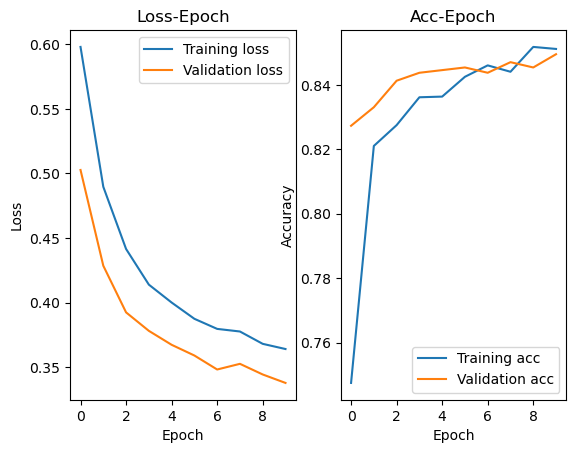

In [ ]:
import matplotlib.pyplot as plt
for epoch in range(num_epoch):
    train_loss = 0
    i = 1
    correct_num = 0
    for batch_data in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epoch}"):
        model.train() # training mode
        batch_data = to_device(batch_data)
        output = model(**batch_data)
        loss = loss_fun(output, batch_data['labels'])
        loss.backward()
        train_loss+=loss.item()

        optimizer.step()
        optimizer.zero_grad()# set gradient to 0 when batch is updated


        # if i % 10 == 0: # record every 10 training batches
        #     output = output.argmax(dim=1)
        #     acc = (output == batch_data['labels']).sum().item()/ len(batch_data['labels'])
        #     print(f'Training stage:Batch {i}, Loss: {loss.item()}, Accuracy: {acc}')

        # if i % 30 == 0: # validate every 30 batches
        #     model.eval()
        #     batch_val = next(iter(valid_loader))
        #     with torch.no_grad():
        #         batch_val = to_device(batch_val)
        #         output = model(**batch_val)
        #     val_loss = loss_fun(output, torch.tensor(batch_val['labels']))
        #     output = output.argmax(dim=1)
        #     acc = (output == torch.tensor(batch_val['labels'])).sum().item()/ len(batch_val['labels'])
        #     print(f'Validation stage:Batch {i}, Loss: {loss.item()}, Accuracy: {acc}')

        # i+=1
        output = output.argmax(dim=1)
        correct_num += (output == batch_data['labels']).sum().item()

    acc = correct_num/ (len(train_loader)*batch_size)
    average_loss = train_loss/len(train_loader)
    loss_hists['train'].append(average_loss)
    acc_hists['train'].append(acc)
    print(f"Epoch {epoch + 1}/{num_epoch}, Training Loss: {average_loss:.4f}, Training accuracy: {acc:.4f}")

    # validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct_num = 0
        for i, batch_data in enumerate(valid_loader):
            batch_data = to_device(batch_data)
            output = model(**batch_data)
            loss = loss_fun(output, batch_data['labels'])
            output = output.argmax(dim=1)

            correct_num += (output == batch_data['labels']).sum().item()
            val_loss+=loss

        acc = correct_num/ (len(valid_loader)*batch_size)
        average_val_loss = val_loss/len(valid_loader)

        loss_hists['val'].append(average_val_loss)
        acc_hists['val'].append(acc)
        print(f'Epoch {epoch + 1}/{num_epoch}, Validation loss: {average_val_loss:.4f}, Validation accuracy: {acc:.4f}')


torch.save(model.state_dict(), 'model_parameters.pth')
torch.save(model, 'model_file.pth')

# draw the loss figures
fig, ax = plt.subplots(1,2)
ax[0].plot(torch.tensor(loss_hists['train']).cpu().detach().numpy()) # can only matplotlib to plot numpy on CPU
ax[0].plot(torch.tensor(loss_hists['val']).cpu().detach().numpy())
ax[0].set_title('Loss-Epoch')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(['Training loss', 'Validation loss'])

ax[1].plot(torch.tensor(acc_hists['train']).cpu().detach().numpy())
ax[1].plot(torch.tensor(acc_hists['val']).cpu().detach().numpy())
ax[1].set_title('Acc-Epoch')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend(['Training acc', 'Validation acc'])
plt.show()

# Method 2: LoRA fine-tuning

In [ ]:
!pip install accelerate loralib peft

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForMaskedLM, BitsAndBytesConfig
model_id = "bert-base-chinese"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForMaskedLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    use_cache=False,
)

`low_cpu_mem_usage` was None, now set to True since model is quantized.
c:\Users\JASONZ7\.conda\envs\pytorch\lib\site-packages\bitsandbytes\cuda_setup\main.py:167: UserWarning: Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes


  warn(msg)
c:\Users\JASONZ7\.conda\envs\pytorch\lib\site-packages\bitsandbytes\cuda_setup\main.py:167: UserWarning: C:\Users\JASONZ7\.conda\envs\pytorch did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)


False

===================================BUG REPORT===================================
The following directories listed in your path were found to be non-existent: {WindowsPath('C'), WindowsPath('/Users/JASONZ7/.conda/envs/pytorch/lib')}
The following directories listed in your path were found to be non-existent: {WindowsPath('vs/workbench/api/node/extensionHostProcess')}
The following directories listed in your path were found to be non-existent: {WindowsPath('/matplotlib_inline.backend_inline'), WindowsPath('module')}
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
The following directories listed in your path were found to be non-existent: {WindowsPath('/usr/local/cuda/lib64')}
DEBUG: Possible options found for libcudart.so: set()
CUDA SETUP: PyTorch settings found: CUDA_VERSION=116, Highest Compute Capability: 8.6.
CUDA SETUP: To manually override the PyTorch CUDA version please see:https://github.com/TimDettmers/bitsandbytes/blo

RuntimeError: Failed to import transformers.integrations.bitsandbytes because of the following error (look up to see its traceback):

        CUDA Setup failed despite GPU being available. Please run the following command to get more information:

        python -m bitsandbytes

        Inspect the output of the command and see if you can locate CUDA libraries. You might need to add them
        to your LD_LIBRARY_PATH. If you suspect a bug, please take the information from python -m bitsandbytes
        and open an issue at: https://github.com/TimDettmers/bitsandbytes/issues